In [1]:
# STEP 1 — Data Loading & Cleaning 
import pandas as pd
import numpy as np
import re
from pathlib import Path

# -----------------------
# Config: dataset path
# -----------------------
disease_fp = "dataset.csv"

# Check file exists
if not Path(disease_fp).exists():
    raise FileNotFoundError(f"⚠️ File '{disease_fp}' not found. Adjust the path and re-run.")

# -----------------------
# 1) Load dataset
# -----------------------
df = pd.read_csv(disease_fp, low_memory=False)
print("Initial shape:", df.shape)
print("Columns:", df.columns.tolist())

# -----------------------
# 2) Normalize text values
# -----------------------
def normalize_text(x):
    """Strip, lowercase, remove punctuation (except underscores), replace spaces with underscores."""
    if pd.isna(x):
        return np.nan
    x = str(x).strip().lower()
    if x in ("", "nan", "none", "na", "n/a", "null"):
        return np.nan
    x = re.sub(r"[^a-z0-9_ ]+", "", x)
    x = re.sub(r"\s+", "_", x.strip())
    return x if x != "" else np.nan

# Normalize column names
df.columns = [c.strip().lower() for c in df.columns]

# Find disease column
if "disease" not in df.columns:
    possible = [c for c in df.columns if "dise" in c or "diagnosis" in c]
    if possible:
        df.rename(columns={possible[0]: "disease"}, inplace=True)
    else:
        raise ValueError("Could not find a 'disease' column in dataset.")

# -----------------------
# 3) Normalize all text columns
# -----------------------
for col in df.columns:
    df[col] = df[col].apply(normalize_text)

# -----------------------
# 4) Remove duplicates, reset index
# -----------------------
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)

# -----------------------
# 5) Create a combined list of symptoms
# -----------------------
symptom_cols = [c for c in df.columns if c != "disease"]
df['symptoms_list'] = df[symptom_cols].apply(lambda row: [v for v in row.tolist() if pd.notna(v)], axis=1)

# -----------------------
# 6) Quick summary
# -----------------------
print("\nAfter cleaning:")
print(" - shape:", df.shape)
print(" - unique diseases:", df['disease'].nunique())
print(" - sample rows:")
display(df[['disease', 'symptoms_list']].head(8))

# -----------------------
# 7) Save cleaned dataset
# -----------------------
df.to_csv("dataset_cleaned.csv", index=False)
print("\nSaved cleaned dataset as 'dataset_cleaned.csv'")

Initial shape: (4920, 18)
Columns: ['Disease', 'Symptom_1', 'Symptom_2', 'Symptom_3', 'Symptom_4', 'Symptom_5', 'Symptom_6', 'Symptom_7', 'Symptom_8', 'Symptom_9', 'Symptom_10', 'Symptom_11', 'Symptom_12', 'Symptom_13', 'Symptom_14', 'Symptom_15', 'Symptom_16', 'Symptom_17']

After cleaning:
 - shape: (304, 19)
 - unique diseases: 41
 - sample rows:


,disease,symptoms_list
0,fungal_infection,"[itching, skin_rash, nodal_skin_eruptions, dis..."
1,fungal_infection,"[skin_rash, nodal_skin_eruptions, dischromic__..."
2,fungal_infection,"[itching, nodal_skin_eruptions, dischromic__pa..."
3,fungal_infection,"[itching, skin_rash, dischromic__patches]"
4,fungal_infection,"[itching, skin_rash, nodal_skin_eruptions]"
5,allergy,"[continuous_sneezing, shivering, chills, water..."
6,allergy,"[shivering, chills, watering_from_eyes]"
7,allergy,"[continuous_sneezing, chills, watering_from_eyes]"



Saved cleaned dataset as 'dataset_cleaned.csv'


In [2]:
# STEP 2 — Feature Encoding 
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
import ast
import joblib

# Load cleaned dataset
df = pd.read_csv("dataset_cleaned.csv")

# Convert string representation of list back to Python list
df['symptoms_list'] = df['symptoms_list'].apply(ast.literal_eval)

# Encode symptom features
mlb = MultiLabelBinarizer()
X = mlb.fit_transform(df['symptoms_list'])
symptom_features = mlb.classes_

# Encode disease labels
le = LabelEncoder()
y = le.fit_transform(df['disease'])

# Quick sanity check (optional)
print("Feature matrix shape:", X.shape)
print("Label vector shape:", y.shape)
print("Unique diseases:", len(le.classes_))

# Save encoders for later use
joblib.dump(mlb, "symptom_mlb.pkl")
joblib.dump(le, "disease_label_encoder.pkl")
print("Encoders saved ✅")


Feature matrix shape: (304, 131)
Label vector shape: (304,)
Unique diseases: 41
Encoders saved ✅


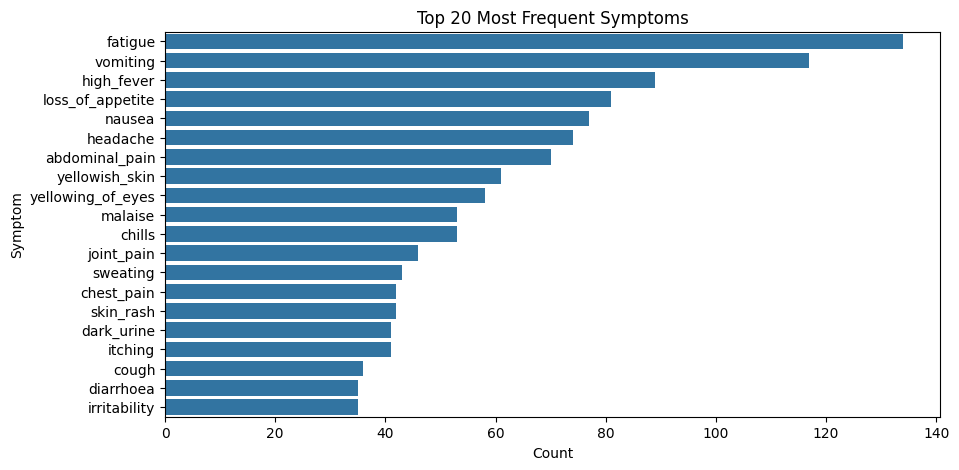

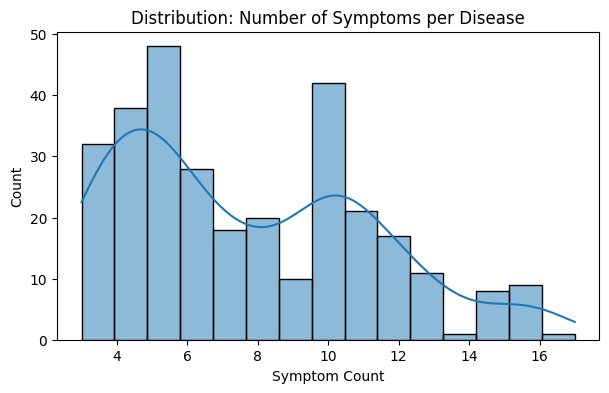

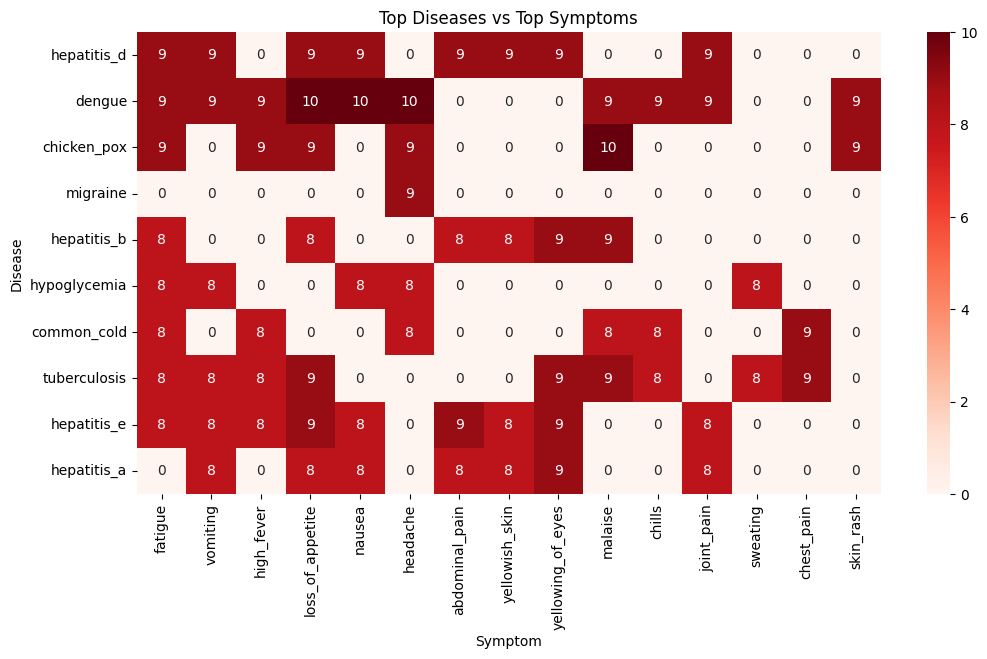

In [5]:
# STEP 3 — Exploratory Data Analysis (EDA) 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import joblib
import ast

# Load cleaned dataset & encoders
df = pd.read_csv("dataset_cleaned.csv")
df["symptoms_list"] = df["symptoms_list"].apply(ast.literal_eval)
mlb = joblib.load("symptom_mlb.pkl")
le = joblib.load("disease_label_encoder.pkl")

# -----------------------
# Disease Frequency
# -----------------------
# plt.figure(figsize=(10,5))
# sns.countplot(y="disease", data=df, order=df["disease"].value_counts().index)
# plt.title("Top Diseases by Frequency")
# plt.xlabel("Count")
# plt.ylabel("Disease")
# plt.show()

# -----------------------
# Symptom Frequency (Top 20)
# -----------------------
symptom_counts = Counter([s for lst in df["symptoms_list"] for s in lst])
symptom_df = pd.DataFrame(symptom_counts.items(), columns=["Symptom", "Count"]).sort_values(by="Count", ascending=False)

plt.figure(figsize=(10,5))
sns.barplot(x="Count", y="Symptom", data=symptom_df.head(20))
plt.title("Top 20 Most Frequent Symptoms")
plt.show()

# -----------------------
# Number of Symptoms per Disease
# -----------------------
df["symptom_count"] = df["symptoms_list"].apply(len)
plt.figure(figsize=(7,4))
sns.histplot(df["symptom_count"], bins=15, kde=True)
plt.title("Distribution: Number of Symptoms per Disease")
plt.xlabel("Symptom Count")
plt.show()

# -----------------------
# Disease–Symptom Heatmap (Top 10 Diseases × Top 15 Symptoms)
# -----------------------
top_diseases = df["disease"].value_counts().index[:10]
top_symptoms = symptom_df["Symptom"].head(15)

heatmap_data = pd.DataFrame(
    0, index=top_diseases, columns=top_symptoms
)
for d in top_diseases:
    disease_symptoms = [s for lst in df[df["disease"]==d]["symptoms_list"] for s in lst]
    heatmap_data.loc[d] = [disease_symptoms.count(s) for s in top_symptoms]

plt.figure(figsize=(12,6))
sns.heatmap(heatmap_data, cmap="Reds", annot=True, fmt="d")
plt.title("Top Diseases vs Top Symptoms")
plt.xlabel("Symptom")
plt.ylabel("Disease")
plt.show()


Training shape: (243, 131), Test shape: (61, 131)

🩺 Naive Bayes — Accuracy: 0.9672
                                      precision    recall  f1-score   support

                                acne       1.00      1.00      1.00         1
                                aids       1.00      1.00      1.00         1
                 alcoholic_hepatitis       1.00      1.00      1.00         2
                             allergy       1.00      1.00      1.00         1
                           arthritis       1.00      1.00      1.00         1
                    bronchial_asthma       1.00      1.00      1.00         1
                cervical_spondylosis       1.00      1.00      1.00         1
                         chicken_pox       1.00      1.00      1.00         2
                 chronic_cholestasis       1.00      1.00      1.00         2
                         common_cold       1.00      1.00      1.00         2
                              dengue       1.00      1.00

D:\Anaconda\envs\tf_1\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\envs\tf_1\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\envs\tf_1\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



🩺 Logistic Regression — Accuracy: 1.0000
                                      precision    recall  f1-score   support

                                acne       1.00      1.00      1.00         1
                                aids       1.00      1.00      1.00         1
                 alcoholic_hepatitis       1.00      1.00      1.00         2
                             allergy       1.00      1.00      1.00         1
                           arthritis       1.00      1.00      1.00         1
                    bronchial_asthma       1.00      1.00      1.00         1
                cervical_spondylosis       1.00      1.00      1.00         1
                         chicken_pox       1.00      1.00      1.00         2
                 chronic_cholestasis       1.00      1.00      1.00         2
                         common_cold       1.00      1.00      1.00         2
                              dengue       1.00      1.00      1.00         2
                     

D:\Anaconda\envs\tf_1\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\envs\tf_1\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Anaconda\envs\tf_1\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ganta\AppData\Local\Temp\ipykernel_3132\

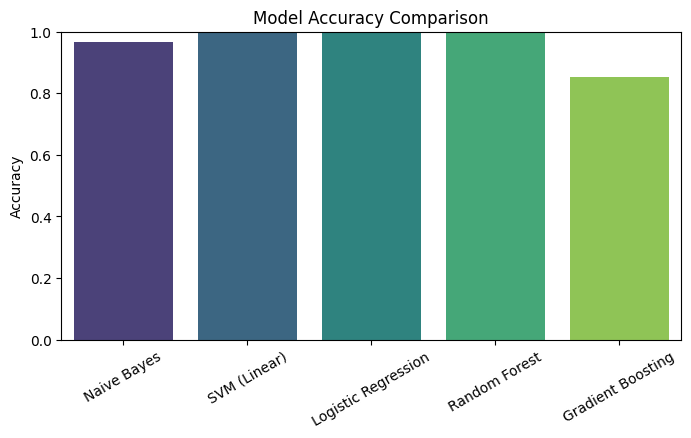


✅ Best model saved: SVM (Linear) (1.0000 accuracy)


In [12]:
# STEP 4 — Model Building 
import pandas as pd
import numpy as np
import joblib, ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# -----------------------
# Load data & encoders
# -----------------------
df = pd.read_csv("dataset_cleaned.csv")
df["symptoms_list"] = df["symptoms_list"].apply(ast.literal_eval)
mlb = joblib.load("symptom_mlb.pkl")
le = joblib.load("disease_label_encoder.pkl")

# Features and labels
X = mlb.transform(df["symptoms_list"])
y = le.transform(df["disease"])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Training shape: {X_train.shape}, Test shape: {X_test.shape}")

# -----------------------
# Define models
# -----------------------
models = {
    "Naive Bayes": MultinomialNB(),
    "SVM (Linear)": SVC(kernel="linear", probability=True, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=150, random_state=42),
}

# -----------------------
# Train & Evaluate models
# -----------------------
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    print(f"\n🩺 {name} — Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

# -----------------------
# Visualize model comparison
# -----------------------
plt.figure(figsize=(8,4))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.xticks(rotation=30)
plt.show()

# -----------------------
# Save best model
# -----------------------
best_model_name = max(results, key=results.get)
best_model = models[best_model_name]
joblib.dump(best_model, "model.pkl")
print(f"\n✅ Best model saved: {best_model_name} ({results[best_model_name]:.4f} accuracy)")


In [7]:
import joblib
import numpy as np

# -------------------------------
# Load Trained Model and Encoders
# -------------------------------
best_model = joblib.load("best_disease_model.pkl")
mlb = joblib.load("symptom_mlb.pkl")
le = joblib.load("disease_label_encoder.pkl")

# -------------------------------
# Function to Predict Disease
# -------------------------------
def predict_disease(symptoms):
    """Predict the disease based on given symptoms."""
    
    # Clean and validate input symptoms
    symptoms = [s.strip().lower() for s in symptoms]
    valid = [s for s in symptoms if s in mlb.classes_]
    invalid = [s for s in symptoms if s not in mlb.classes_]

    # Warn about invalid symptoms
    for s in invalid:
        print(f"⚠️ '{s}' not found in training symptom list")

    if not valid:
        return "❌ No valid symptoms found in input."

    # One-hot encode and predict
    input_vector = mlb.transform([valid])
    predicted_label = best_model.predict(input_vector)[0]
    predicted_disease = le.inverse_transform([predicted_label])[0]

    return f"🩺 Predicted Disease: {predicted_disease}"

# -------------------------------
# Example Usage
# -------------------------------
user_symptoms = ["muscle_wasting","patches_in_throat","high_fever","extra_marital_contacts","passage_of_gases"]

print(predict_disease(user_symptoms))


🩺 Predicted Disease: aids


In [8]:
import pandas as pd

# Load datasets
precautions = pd.read_csv('precautions_df.csv')
workout = pd.read_csv('workout_df.csv')
description = pd.read_csv('description.csv')
medications = pd.read_csv('medications.csv')
diets = pd.read_csv('diets.csv')

# Function to explore dataset
def explore_df(df, name):
    print(f"\n--- {name} ---")
    print("Shape:", df.shape)
    print("Columns:", df.columns.tolist())
    print("\nFirst 5 rows:")
    display(df.head())
    print("\nMissing values:")
    print(df.isnull().sum())

# Explore all datasets
explore_df(precautions, "Precautions")
explore_df(workout, "Workout")
explore_df(description, "Description")
explore_df(medications, "Medications")
explore_df(diets, "Diets")



--- Precautions ---
Shape: (41, 6)
Columns: ['Unnamed: 0', 'Disease', 'Precaution_1', 'Precaution_2', 'Precaution_3', 'Precaution_4']

First 5 rows:


,Unnamed: 0,Disease,Precaution_1,Precaution_2,Precaution_3,Precaution_4
0,0,Drug Reaction,stop irritation,consult nearest hospital,stop taking drug,follow up
1,1,Malaria,Consult nearest hospital,avoid oily food,avoid non veg food,keep mosquitos out
2,2,Allergy,apply calamine,cover area with bandage,NaN,use ice to compress itching
3,3,Hypothyroidism,reduce stress,exercise,eat healthy,get proper sleep
4,4,Psoriasis,wash hands with warm soapy water,stop bleeding using pressure,consult doctor,salt baths



Missing values:
Unnamed: 0      0
Disease         0
Precaution_1    0
Precaution_2    0
Precaution_3    1
Precaution_4    1
dtype: int64

--- Workout ---
Shape: (410, 4)
Columns: ['Unnamed: 0.1', 'Unnamed: 0', 'disease', 'workout']

First 5 rows:


,Unnamed: 0.1,Unnamed: 0,disease,workout
0,0,0,Fungal infection,Avoid sugary foods
1,1,1,Fungal infection,Consume probiotics
2,2,2,Fungal infection,Increase intake of garlic
3,3,3,Fungal infection,Include yogurt in diet
4,4,4,Fungal infection,Limit processed foods



Missing values:
Unnamed: 0.1    0
Unnamed: 0      0
disease         0
workout         0
dtype: int64

--- Description ---
Shape: (41, 2)
Columns: ['Disease', 'Description']

First 5 rows:


,Disease,Description
0,Fungal infection,Fungal infection is a common skin condition ca...
1,Allergy,Allergy is an immune system reaction to a subs...
2,GERD,GERD (Gastroesophageal Reflux Disease) is a di...
3,Chronic cholestasis,Chronic cholestasis is a condition where bile ...
4,Drug Reaction,Drug Reaction occurs when the body reacts adve...



Missing values:
Disease        0
Description    0
dtype: int64

--- Medications ---
Shape: (41, 2)
Columns: ['Disease', 'Medication']

First 5 rows:


,Disease,Medication
0,Fungal infection,"['Antifungal Cream', 'Fluconazole', 'Terbinafi..."
1,Allergy,"['Antihistamines', 'Decongestants', 'Epinephri..."
2,GERD,"['Proton Pump Inhibitors (PPIs)', 'H2 Blockers..."
3,Chronic cholestasis,"['Ursodeoxycholic acid', 'Cholestyramine', 'Me..."
4,Drug Reaction,"['Antihistamines', 'Epinephrine', 'Corticoster..."



Missing values:
Disease       0
Medication    0
dtype: int64

--- Diets ---
Shape: (41, 2)
Columns: ['Disease', 'Diet']

First 5 rows:


,Disease,Diet
0,Fungal infection,"['Antifungal Diet', 'Probiotics', 'Garlic', 'C..."
1,Allergy,"['Elimination Diet', 'Omega-3-rich foods', 'Vi..."
2,GERD,"['Low-Acid Diet', 'Fiber-rich foods', 'Ginger'..."
3,Chronic cholestasis,"['Low-Fat Diet', 'High-Fiber Diet', 'Lean prot..."
4,Drug Reaction,"['Antihistamine Diet', 'Omega-3-rich foods', '..."



Missing values:
Disease    0
Diet       0
dtype: int64


In [9]:
import pandas as pd
import ast

# ----------------------------------------
# Utility function to clean disease column
# ----------------------------------------
def clean_disease_col(df, col_name):
    df[col_name] = (
        df[col_name]
        .astype(str)
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
        .str.replace(r"[^a-z_]", "", regex=True)
    )
    return df

# ----------------------------------------
# Precautions Dataset
# ----------------------------------------
precautions = pd.read_csv("precautions_df.csv")
precautions = precautions.drop(columns=[c for c in precautions.columns if "Unnamed" in c], errors="ignore")
precautions = clean_disease_col(precautions, "Disease")
for col in ["Precaution_1", "Precaution_2", "Precaution_3", "Precaution_4"]:
    precautions[col] = precautions[col].fillna("").str.strip()
precautions = precautions.drop_duplicates(subset="Disease")
precautions.to_csv("precautions_cleaned.csv", index=False)
print("✅ precautions_cleaned.csv saved")

# ----------------------------------------
# Workout Dataset
# ----------------------------------------
workout = pd.read_csv("workout_df.csv")
workout = workout.drop(columns=[c for c in workout.columns if "Unnamed" in c], errors="ignore")
workout = clean_disease_col(workout, "disease")
workout["workout"] = workout["workout"].fillna("").str.strip()
workout = workout.drop_duplicates(subset="disease")
workout.to_csv("workout_cleaned.csv", index=False)
print("✅ workout_cleaned.csv saved")

# ----------------------------------------
# Description Dataset
# ----------------------------------------
description = pd.read_csv("description.csv")
description = description.drop(columns=[c for c in description.columns if "Unnamed" in c], errors="ignore")
description = clean_disease_col(description, "Disease")
description["Description"] = description["Description"].fillna("No description available").str.strip()
description = description.drop_duplicates(subset="Disease")
description.to_csv("description_cleaned.csv", index=False)
print("✅ description_cleaned.csv saved")

# ----------------------------------------
# Medications Dataset
# ----------------------------------------
medications = pd.read_csv("medications.csv")
medications = medications.drop(columns=[c for c in medications.columns if "Unnamed" in c], errors="ignore")
medications = clean_disease_col(medications, "Disease")
medications["Medication"] = medications["Medication"].fillna("[]").apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
medications = medications.drop_duplicates(subset="Disease")
medications.to_csv("medications_cleaned.csv", index=False)
print("✅ medications_cleaned.csv saved")

# ----------------------------------------
# Diets Dataset
# ----------------------------------------
diets = pd.read_csv("diets.csv")
diets = diets.drop(columns=[c for c in diets.columns if "Unnamed" in c], errors="ignore")
diets = clean_disease_col(diets, "Disease")
diets["Diet"] = diets["Diet"].fillna("[]").apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)
diets = diets.drop_duplicates(subset="Disease")
diets.to_csv("diets_cleaned.csv", index=False)
print("✅ diets_cleaned.csv saved")

# ----------------------------------------
# ✅ Summary
# ----------------------------------------
print("\n🎯 All datasets cleaned and saved successfully!")


✅ precautions_cleaned.csv saved
✅ workout_cleaned.csv saved
✅ description_cleaned.csv saved
✅ medications_cleaned.csv saved
✅ diets_cleaned.csv saved

🎯 All datasets cleaned and saved successfully!


In [10]:
# =============================================================
# 🧠 Disease Prediction – Core Setup
# =============================================================
import pandas as pd
import numpy as np
import joblib
import ast

# --- Load model and encoders ---
best_model = joblib.load("best_disease_model.pkl")
mlb = joblib.load("symptom_mlb.pkl")
le = joblib.load("disease_label_encoder.pkl")

# --- Load supporting datasets ---
datasets = {
    "precautions": pd.read_csv("precautions_cleaned.csv"),
    "workout": pd.read_csv("workout_cleaned.csv"),
    "diets": pd.read_csv("diets_cleaned.csv"),
    "medications": pd.read_csv("medications_cleaned.csv"),
    "description": pd.read_csv("description_cleaned.csv")
}

# --- Core function for disease prediction ---
def recommend_for_symptoms(symptoms):
    symptoms = [s.strip().lower() for s in symptoms]
    valid = [s for s in symptoms if s in mlb.classes_]
    invalid = [s for s in symptoms if s not in mlb.classes_]

    if invalid:
        print(f"⚠️ Unrecognized symptoms: {invalid}")

    input_vector = mlb.transform([valid])
    predicted_label = best_model.predict(input_vector)[0]
    disease = le.inverse_transform([predicted_label])[0]

    # Helper to parse stored lists
    def parse(val):
        if pd.isna(val): return []
        if isinstance(val, str) and val.startswith("["):
            try: return ast.literal_eval(val)
            except: return [val]
        return [val]

    rec = {"Disease": disease}
    dsets = datasets  # shortcut

    rec["Description"] = dsets["description"].loc[dsets["description"]["Disease"] == disease, "Description"
    ].squeeze() if not dsets["description"][dsets["description"]["Disease"] == disease].empty else "No description available."

    rec["Medications"] = parse(dsets["medications"].loc[dsets["medications"]["Disease"] == disease, "Medication"].squeeze())

    rec["Diet"] = parse(dsets["diets"].loc[dsets["diets"]["Disease"] == disease, "Diet"].squeeze())

    rec["Workout"] = dsets["workout"].loc[dsets["workout"]["disease"] == disease, "workout"].tolist()

    prec = dsets["precautions"].loc[dsets["precautions"]["Disease"] == disease]
    rec["Precautions"] = [prec.iloc[0][c] for c in ["Precaution_1","Precaution_2","Precaution_3","Precaution_4"]
                          if not prec.empty and pd.notna(prec.iloc[0][c])]

    rec["Symptoms"] = [(s, np.random.randint(1,6)) for s in valid]
    return rec


In [11]:
# =============================================================
# 💊 Report Display – Prescription 
# =============================================================
def display_report(rec):
    line = "=" * 55
    print(f"\n{line}")
    print(f"🩺 Predicted Disease: {rec['Disease'].replace('_', ' ').title()}")
    print(f"{line}\n")

    print("📖 Description:")
    print(f" {rec['Description']}\n")

    print("📋 Symptoms & Severity:")
    for s, sev in rec["Symptoms"]:
        print(f"  • {s.replace('_',' ').title()} (Severity {sev})")
    print()

    print("💊 Medications:")
    for m in rec.get("Medications", []) or ["No data"]:
        print(f"  • {m}")
    print()

    print("⚠️ Precautions:")
    for p in rec.get("Precautions", []) or ["No data"]:
        print(f"  • {p}")
    print()

    print("🥗 Diet Recommendations:")
    for d in rec.get("Diet", []) or ["No data"]:
        print(f"  • {d}")
    print()

    print("🏋️ Workout Recommendations:")
    for w in rec.get("Workout", []) or ["No data"]:
        print(f"  • {w}")
    print(line)
    print("💚 Take care and follow your health plan!\n")

# --- Example Run ---
if __name__ == "__main__":
    user_symptoms = ["itching", "skin_rash", "joint_pain"]
    result = recommend_for_symptoms(user_symptoms)
    display_report(result)



🩺 Predicted Disease: Fungal Infection

📖 Description:
 Fungal infection is a common skin condition caused by fungi.

📋 Symptoms & Severity:
  • Itching (Severity 1)
  • Skin Rash (Severity 1)
  • Joint Pain (Severity 1)

💊 Medications:
  • Antifungal Cream
  • Fluconazole
  • Terbinafine
  • Clotrimazole
  • Ketoconazole

⚠️ Precautions:
  • bath twice
  • use detol or neem in bathing water
  • keep infected area dry
  • use clean cloths

🥗 Diet Recommendations:
  • Antifungal Diet
  • Probiotics
  • Garlic
  • Coconut oil
  • Turmeric

🏋️ Workout Recommendations:
  • Avoid sugary foods
💚 Take care and follow your health plan!

